# Stack QSO spectra

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from astropy.io import fits
from astropy.table import Table
from concurrent.futures import ProcessPoolExecutor

import mfp

---
### Test with "regular" redshift intervals

In [2]:
# Basic settings
path_data = './data/spectra-Iron-QSO-main-dark-zgtr3.fits'
path_bal = './data/QSO_cat_iron_main_dark_healpix_v0-altbal.fits' # BAL catalog
path_prev = './data/previous/'
z_range = (3.2, 3.25, 3.3, 3.35, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.2, 4.4, 4.6)
snr_cut = 3
wvmin = 840

In [3]:
# Print the information of the data
data = fits.open(path_data)
data.info()

Filename: ./data/new_cat/spectra-Iron-QSO-main-dark-zgtr3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU    157   69609R x 74C   [K, D, D, K, 6A, J, D, D, 3A, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, I, K, K, I, E, K, K, K, K, K, K, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, K, 4A, 4A, E, E, J, D, J, D, D, D, E]   
  2  WAVELENGTH    1 ImageHDU         7   (7781,)   float64   
  3  FLUX          1 ImageHDU         8   (7781, 69609)   float64   
  4  IVAR          1 ImageHDU         8   (7781, 69609)   float64   
  5  MASK          1 ImageHDU        10   (7781, 69609)   int32 (rescales to uint32)   


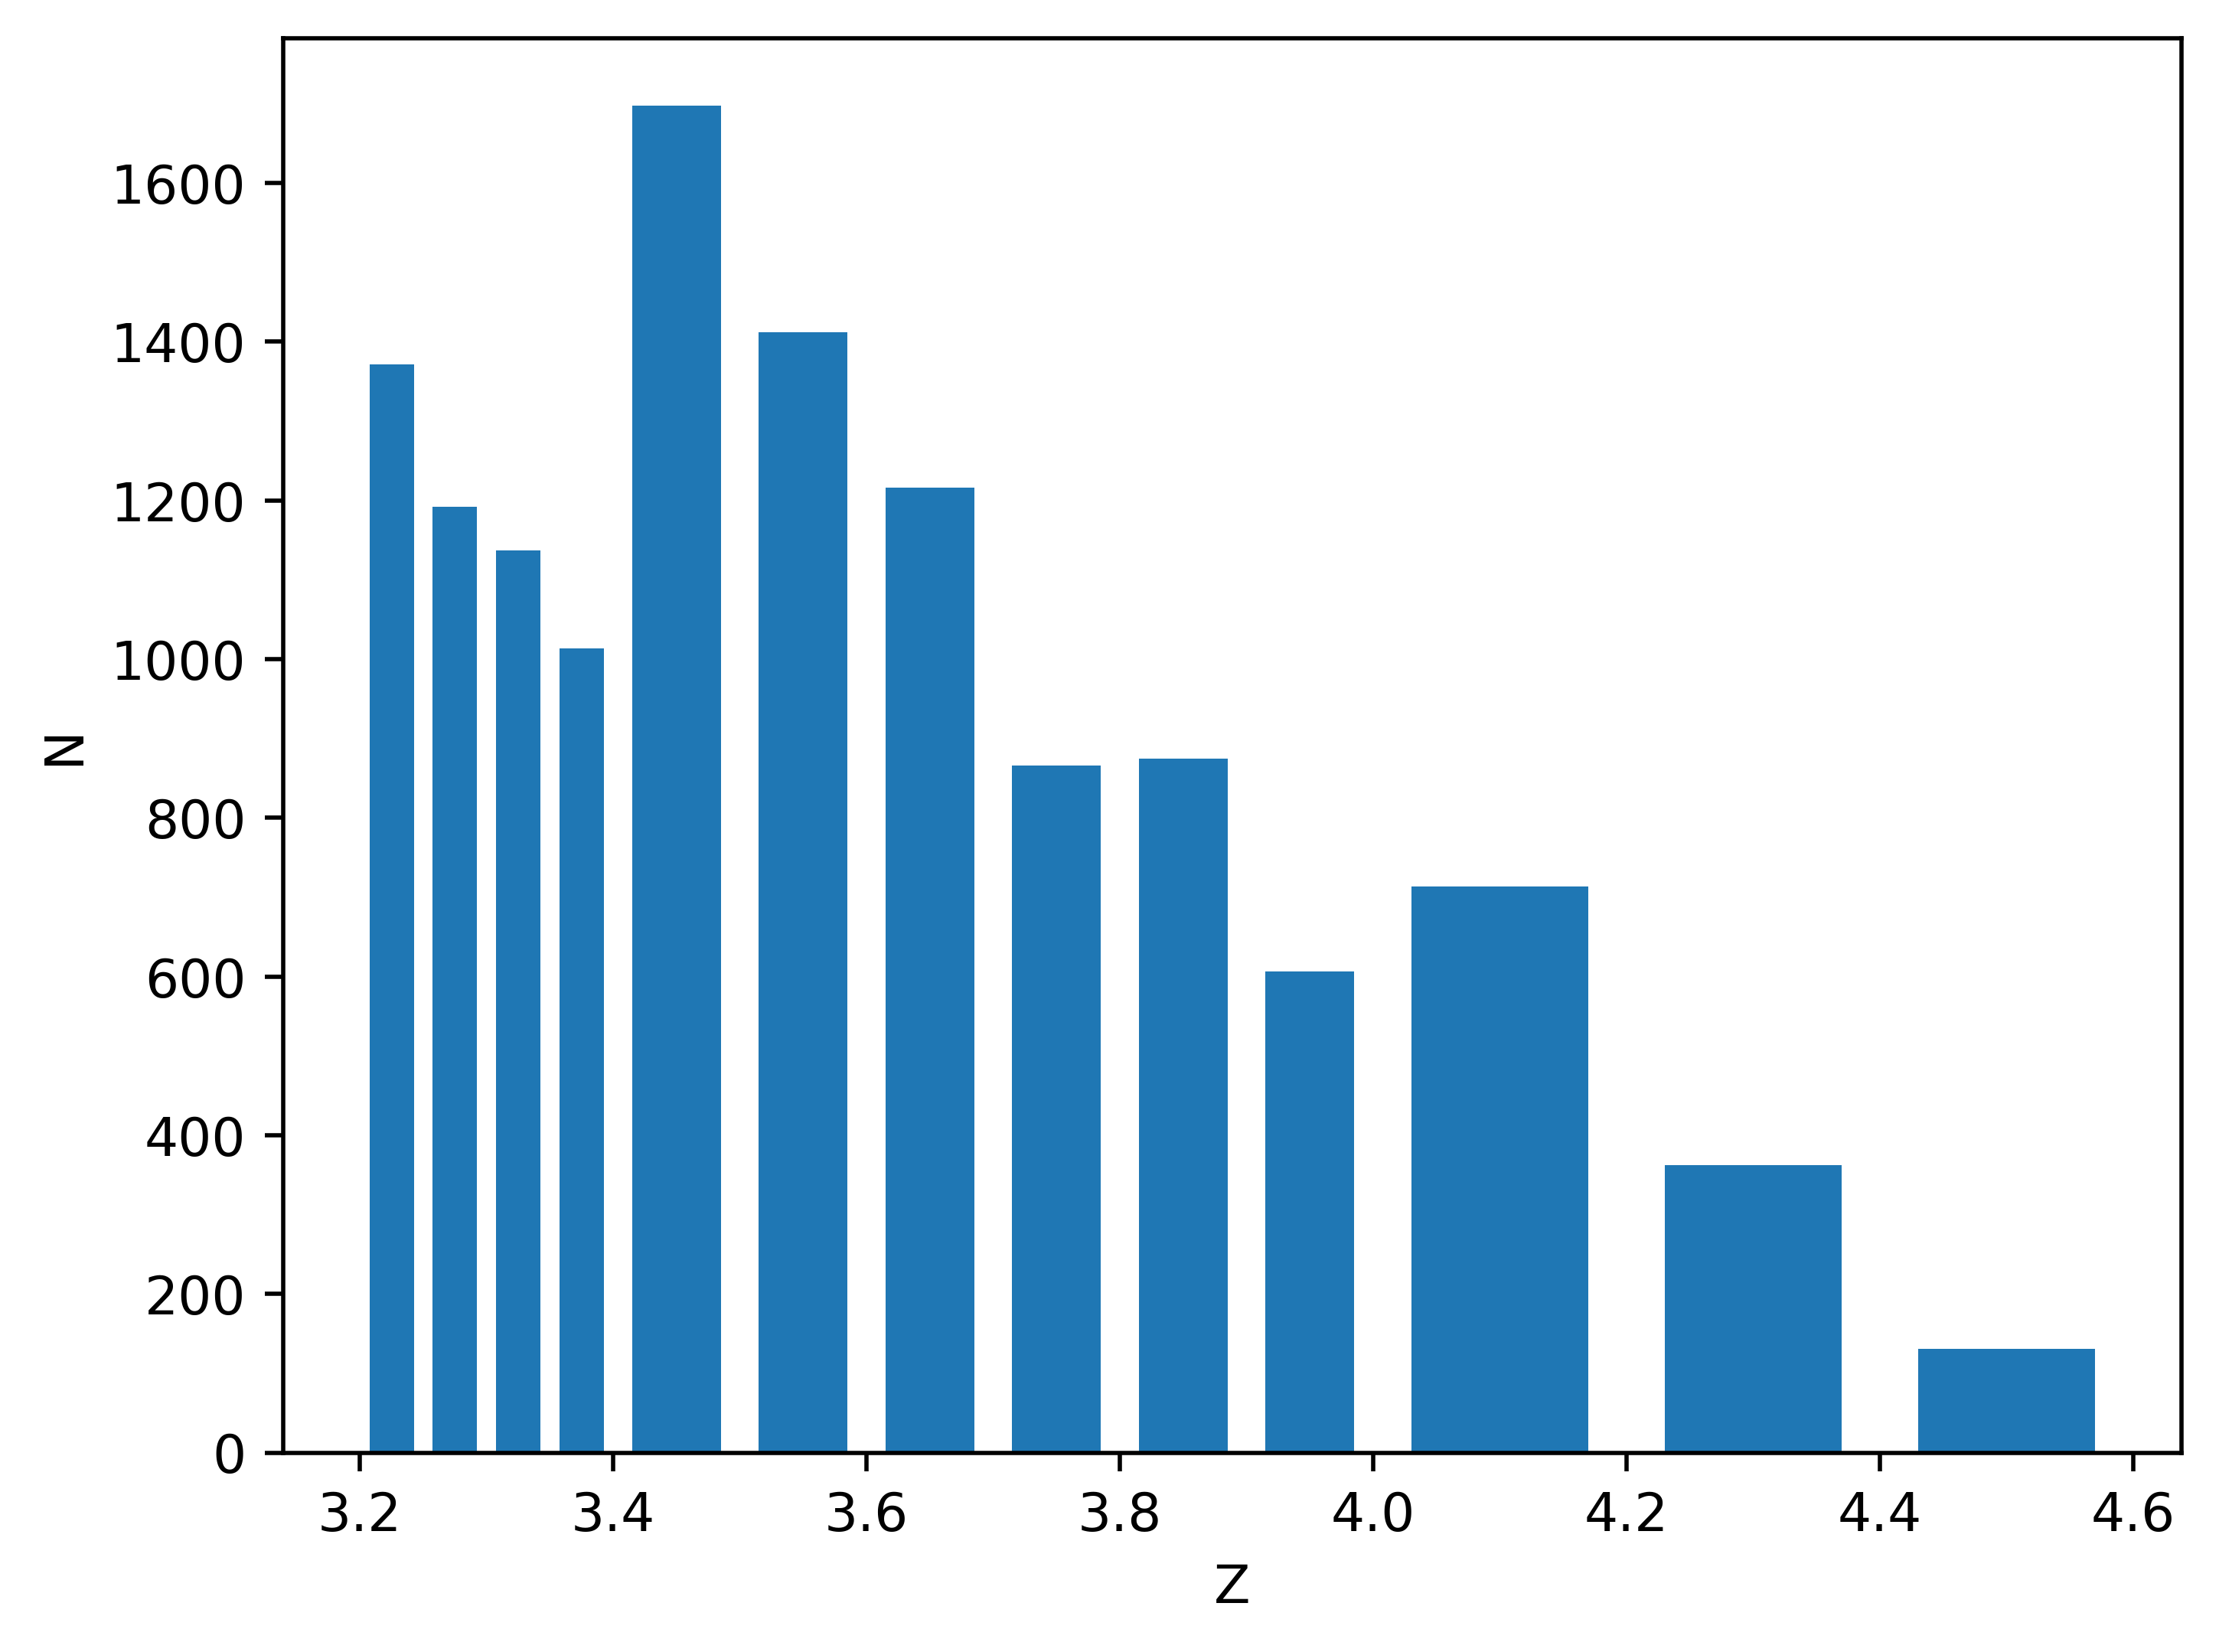

Number of QSOs: 12595


In [4]:
# Load catalogs and draw the number distribution
cat = Table(data[1].data)
# mask zwarn
mask_zwarn = np.array(cat['ZWARN'] == 0)
mask_z = np.array((cat['Z'] >= 3.2)&(cat['Z'] <= 4.6))

# mask bal
data_bal = Table(fits.open(path_bal)[1].data)
index_arr = np.searchsorted(data_bal['TARGETID'], cat['TARGETID'])
data_bal = data_bal[index_arr]
mask_bal = (data_bal['AI_CIV']==0) & (data_bal['AI_SIIV']==0) & (data_bal['BI_CIV']==0) & (data_bal['BI_SIIV']==0)

# mask S/N
mask_snr = np.array(cat['SNR1450'] >= snr_cut)
plt.figure(dpi=500)
plt.hist(cat[mask_snr&mask_bal&mask_zwarn]['Z'], bins=z_range, rwidth=0.7)
plt.xlabel('Z')
plt.ylabel('N')
plt.savefig('./figures/number_distribution.png')
plt.show()
print('Number of QSOs:', np.sum(mask_snr&mask_bal&mask_zwarn&mask_z))

In [5]:
# Validate the masks and the number of QSOs
ids = cat['TARGETID'][mask_snr&mask_bal&mask_zwarn&mask_z]
len(np.unique(ids))

12595

In [6]:
# Load the data and preprocess
wave = np.array(data[2].data.astype(np.float64))
ebv = np.array(cat['EBV'].astype(np.float64))[mask_zwarn&mask_bal]

correction = mfp.utils.deredden(wave, ebv)
mask_total = mask_zwarn&mask_bal
print('correction & mask finished')

zqso = np.array(cat['Z'])[mask_total]
zerr = np.array(cat['ZERR'])[mask_total]
flux = np.array(data[3].data.astype(np.float64))[mask_total] * correction
error = (1/np.sqrt(np.array(data[4].data)))[mask_total] * correction
snr = np.array(cat['SNR1450'])[mask_total]

correction & mask finished


/tmp/ipykernel_3871/3433867157.py:11: RuntimeWarning: divide by zero encountered in divide
  error = (1/np.sqrt(np.array(data[4].data)))[mask_total] * correction


In [7]:
# Calculate redshift error
zerr = (1+zqso) * 350 / 3e5

SNR1450: 3.945730764367451
SNR1250: 5.691469205505064
SNR from catalog: 3.9457307


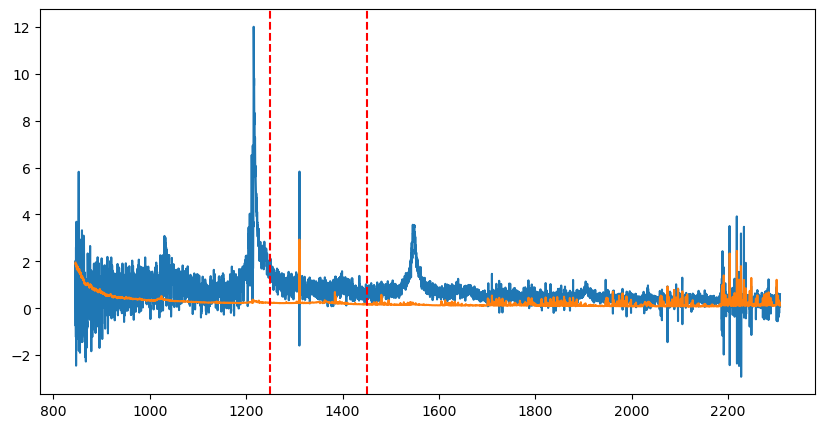

In [8]:
# A showcase of spectrum
index = 10000
plt.figure(figsize=(10, 5))
plt.plot(wave/(1+zqso[index]), flux[index])
plt.plot(wave/(1+zqso[index]), error[index])
plt.axvline(1450, color='red', linestyle='--')
plt.axvline(1250, color='red', linestyle='--')
mask = (wave/(1+zqso[index]) > 1450) & (wave/(1+zqso[index]) < 1470)
snr1450 = np.median(flux[index][mask]/error[index][mask])
print('SNR1450:', snr1450)
mask = (wave/(1+zqso[index]) > 1250) & (wave/(1+zqso[index]) < 1270)
snr1250 = np.median(flux[index][mask]/error[index][mask])
print('SNR1250:', snr1250)
print('SNR from catalog:', snr[index])

In [10]:
# Stacking!
df = pd.read_csv('./data/telfer.asc', sep='\s+', header=None, comment='#')
wave_tel, flux_tel = df[0].values, df[1].values

def stacking(z_interval):
    wave_fin, flux_tot, error_tot, flux_boot, zmed, num, navg, mask_avg = \
        mfp.stack.stack_qsos(wave, flux, error, zqso, snr=snr, z_interval=z_interval, 
                             dwv_fin=0.5, boot_num=1000, boot_size=10000, snr_cut=snr_cut)
    wave_fin = wave_fin[mask_avg]
    flux_tot = flux_tot[mask_avg]
    error_tot = error_tot[mask_avg]
    flux_boot = flux_boot[:,mask_avg]
    sigma_boot = np.std(flux_boot, axis=0)
    flux_telfer = mfp.utils.telfer(wave_fin=wave_fin, wave_ori=wave_tel, flux_telfer_ori=flux_tel)
    np.savez(f'./data/new_cat_350/spec_{z_interval[0]:.3f}-{z_interval[1]:.3f}_snr{snr_cut}_0.5A', 
             wave_fin=wave_fin, flux_tot=flux_tot, error_tot=error_tot, z_interval=np.array(z_interval),
             flux_boot=flux_boot, sigma_boot=sigma_boot, flux_telfer=flux_telfer, zmed=zmed)

with ProcessPoolExecutor(max_workers=len(z_range)-1) as executor:
    executor.map(stacking, [(z_range[i], z_range[i+1]) for i in range(len(z_range)-1)])

100%|██████████| 1698/1698 [00:59<00:00, 28.72it/s]


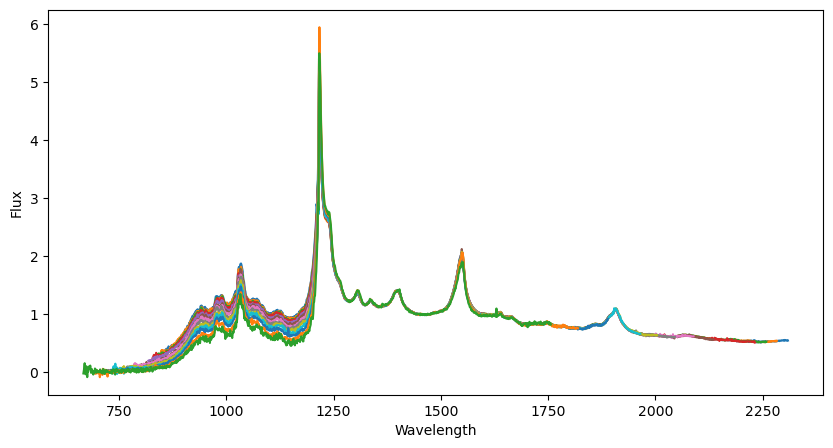

In [11]:
# Show the stacked spectra
plt.figure(figsize=(10, 5))
for i in range(len(z_range)-1):
    data = np.load(f'./data/new_cat/spec_{z_range[i]:.3f}-{z_range[i+1]:.3f}_snr{snr_cut}.npz')
    wave_fin, flux_tot, error_tot, z_interval, flux_boot, sigma_boot, flux_telfer, zmed = \
        data['wave_fin'], data['flux_tot'], data['error_tot'], data['z_interval'], data['flux_boot'], data['sigma_boot'], data['flux_telfer'], data['zmed']
    plt.plot(wave_fin, flux_tot)
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')


-----
### Test with redshift intervals with equal number of QSOs

In [8]:
# Find the redshift intervals
zqso_used = np.sort(zqso[snr > snr_cut])
zqso_used = zqso_used[(zqso_used>=3.2)&(zqso_used<=4.6)]

i, zi, num_crit = 0, 3.2, 1000
z_range_even = [3.2,]
for j in range(len(zqso_used)-1):
    z = zqso_used[j]
    num = np.sum((zqso_used<=z)&(zqso_used>zi))
    if num == 1000 and np.sum(zqso_used<=z)<=9000:
        zi_new = (z + zqso_used[j+1])/2
        print(f'Number of QSOs within {zi:.3f}-{zi_new:.3f}: {num}, Median redshift: {np.median(zqso_used[(zqso_used<=zi_new)&(zqso_used>zi)]):.3f}')
        zi = zi_new
        z_range_even.append(zi)
    elif num == 500 and np.sum(zqso_used<=z)>9000:
        zi_new = (z + zqso_used[j+1])/2
        print(f'Number of QSOs within {zi:.3f}-{zi_new:.3f}: {num}, Median redshift: {np.median(zqso_used[(zqso_used<=zi_new)&(zqso_used>zi)]):.3f}')
        zi = zi_new
        z_range_even.append(zi)
z_range_even.append(4.6)
print(f'Number of QSOs within {zi:.3f}-4.600: {np.sum(zqso_used>zi)}, Median redshift: {np.median(zqso_used[(zqso_used<=4.6)&(zqso_used>zi)]):.3f}')
print('New z range:', z_range_even)

Number of QSOs within 3.200-3.236: 1000, Median redshift: 3.217
Number of QSOs within 3.236-3.275: 1000, Median redshift: 3.255
Number of QSOs within 3.275-3.320: 1000, Median redshift: 3.297
Number of QSOs within 3.320-3.364: 1000, Median redshift: 3.341
Number of QSOs within 3.364-3.415: 1000, Median redshift: 3.389
Number of QSOs within 3.415-3.474: 1000, Median redshift: 3.443
Number of QSOs within 3.474-3.539: 1000, Median redshift: 3.506
Number of QSOs within 3.539-3.613: 1000, Median redshift: 3.577
Number of QSOs within 3.613-3.696: 1000, Median redshift: 3.653
Number of QSOs within 3.696-3.756: 500, Median redshift: 3.724
Number of QSOs within 3.756-3.808: 500, Median redshift: 3.782
Number of QSOs within 3.808-3.866: 500, Median redshift: 3.837
Number of QSOs within 3.866-3.931: 500, Median redshift: 3.896


Number of QSOs within 3.931-4.024: 500, Median redshift: 3.976
Number of QSOs within 4.024-4.161: 500, Median redshift: 4.082
Number of QSOs within 4.161-4.434: 500, Median redshift: 4.270
Number of QSOs within 4.434-4.600: 95, Median redshift: 4.489
New z range: [3.2, 3.236285875312443, 3.2745167424009614, 3.319706237513413, 3.3643644672482784, 3.4147070053226742, 3.474041762293245, 3.539306814278147, 3.6125151327532627, 3.696172321903557, 3.7561335840511836, 3.8083515142011777, 3.8659488830382367, 3.9307299929198147, 4.024144390540355, 4.160885808343979, 4.434181175847218, 4.6]


In [9]:
# Stacking!
from multiprocessing.pool import Pool
df = pd.read_csv('./data/telfer.asc', sep='\s+', header=None, comment='#')
wave_tel, flux_tel = df[0].values, df[1].values

def stacking(z_interval):
    print(f'Processing {z_interval[0]:.3f}-{z_interval[1]:.3f}')
    wave_fin, flux_tot, error_tot, flux_boot, zmed, num, navg, mask_avg = \
        mfp.stack.stack_qsos(wave, flux, error, zqso, snr=snr, z_interval=z_interval, zerr=zerr,
                             dwv_fin=0.5, boot_num=1000, boot_size=10000, snr_cut=snr_cut)
    wave_fin = wave_fin[mask_avg]
    flux_tot = flux_tot[mask_avg]
    error_tot = error_tot[mask_avg]
    flux_boot = flux_boot[:,mask_avg]
    sigma_boot = np.std(flux_boot, axis=0)
    flux_telfer = mfp.utils.telfer(wave_fin=wave_fin, wave_ori=wave_tel, flux_telfer_ori=flux_tel)
    np.savez(f'./data/new_cat_350/spec_{z_interval[0]:.3f}-{z_interval[1]:.3f}_snr{snr_cut}_even_0.5A', 
             wave_fin=wave_fin, flux_tot=flux_tot, error_tot=error_tot, z_interval=np.array(z_interval),
             flux_boot=flux_boot, sigma_boot=sigma_boot, flux_telfer=flux_telfer, zmed=zmed)

with ProcessPoolExecutor(max_workers=1) as executor:
# with Pool(2) as executor:
    executor.map(stacking, [(z_range_even[i], z_range_even[i+1]) for i in range(len(z_range_even)-1)])


Processing 3.200-3.236


Bootstrapping with redshift error...:   3%|▎         | 27/1000 [17:29<10:26:01, 38.60s/it]

In [28]:
# Print basic information
for file in os.listdir('./data/new_cat/'):
    if re.search('spec_[0-9]+\.[0-9]+-[0-9]+\.[0-9]+_snr[0-9]+_even_0\.5A.npz', file):
        data = np.load(f'./data/new_cat/{file}')
        z_interval, zmed = data['z_interval'], data['zmed']
        print(f'z_interval: {z_interval}, zmed: {zmed}')

z_interval: [3.80835151 3.86594888], zmed: 3.83747257357207
z_interval: [4.43418118 4.6       ], zmed: 4.489459085977328
z_interval: [3.93072999 4.02414439], zmed: 3.9756807052724215
z_interval: [3.31970624 3.36436447], zmed: 3.3407040718019685
z_interval: [3.23628588 3.27451674], zmed: 3.2548975872498365
z_interval: [3.27451674 3.31970624], zmed: 3.297215422048154
z_interval: [3.47404176 3.53930681], zmed: 3.5062141185546007
z_interval: [4.16088581 4.43418118], zmed: 4.2701888002839
z_interval: [3.53930681 3.61251513], zmed: 3.5768515868044592
z_interval: [3.61251513 3.69617232], zmed: 3.6525342508050302
z_interval: [3.2        3.23628588], zmed: 3.217146254825196
z_interval: [3.86594888 3.93072999], zmed: 3.89604106837613
z_interval: [3.69617232 3.75613358], zmed: 3.723855924748873
z_interval: [3.41470701 3.47404176], zmed: 3.4434796386656785
z_interval: [3.75613358 3.80835151], zmed: 3.78234228692585
z_interval: [3.36436447 3.41470701], zmed: 3.3890298502828227
z_interval: [4.024144

## Stack at Prochaska 2009 redshift ranges

In [7]:
# Load the P09 catalog
cat = Table(fits.open('./data/previous/sdss_mfp_summ.fits')[1].data)[-7:]
z_range_sdss = [cat['ZMNX'][:, 0][i] for i in range(7)]
z_range_sdss.append(cat['ZMNX'][:, 1][-1])
z_range_sdss

[3.71, 3.76, 3.81, 3.85, 3.92, 4.02, 4.13, 4.33]

In [8]:
# Stacking!
df = pd.read_csv('./data/telfer.asc', sep='\s+', header=None, comment='#')
wave_tel, flux_tel = df[0].values, df[1].values

def stacking(z_interval):
    wave_fin, flux_tot, error_tot, flux_boot, zmed, num, navg, mask_avg = \
        mfp.stack.stack_qsos(wave, flux, error, zqso, snr=snr, z_interval=z_interval, 
                             dwv_fin=0.5, boot_num=1000, boot_size=10000, snr_cut=snr_cut)
    wave_fin = wave_fin[mask_avg]
    flux_tot = flux_tot[mask_avg]
    error_tot = error_tot[mask_avg]
    flux_boot = flux_boot[:,mask_avg]
    sigma_boot = np.std(flux_boot, axis=0)
    flux_telfer = mfp.utils.telfer(wave_fin=wave_fin, wave_ori=wave_tel, flux_telfer_ori=flux_tel)
    np.savez(f'./data/spec_{z_interval[0]:.3f}-{z_interval[1]:.3f}_snr{snr_cut}_0.5A', 
             wave_fin=wave_fin, flux_tot=flux_tot, error_tot=error_tot, z_interval=np.array(z_interval),
             flux_boot=flux_boot, sigma_boot=sigma_boot, flux_telfer=flux_telfer, zmed=zmed)

with ProcessPoolExecutor(max_workers=2) as executor:
    executor.map(stacking, [(z_range_sdss[i], z_range_sdss[i+1]) for i in range(len(z_range_sdss)-1)])


100%|██████████| 462/462 [00:23<00:00, 20.01it/s]  
